# Error Propagation Example

In [2]:
%load_ext line_profiler
%load_ext autoreload
# provide cell timings
%load_ext autotime
%autoreload 2
import sympy as sp
import numpy as np
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False
from qdef import *
from misc import *
from matrixgoodies import *
from IPython.display import display, Math, Latex, HTML
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
import time
from itertools import product, permutations
plt.style.use('dark_background')
from uncertainties import ufloat
from random import choice, sample

Reloading /Users/juan/Zia Lab/Codebase/qdef/data/CPGs.pkl ...


$\textrm{V}^{3+}$ in $\textrm{K}_2\textrm{NaScF}_6$ is quoted by Morrison to have been fit to the following parameters in $\textrm{O}_{h}$ symmetry.

$F^{(2)} = 54761 \textrm{ cm}^{-1} \\
F^{(4)} = 35154 \textrm{ cm}^{-1} \\ 
\zeta = 124 \textrm{ cm}^{-1} \\
B_{4,0} = 32718 \textrm{ cm}^{-1}$

Determine what is the corresponding uncertainty (in energy and in wavelength) to which the transition energies should have been measured with.

Assume that all the given digits are significant figures, with an uncertainty of $\pm{1}$ in the last reported digit. 

In [6]:
num_electrons = 2
sparse = False
hamiltonian = hamiltonian_CF_CR_SO_TO(num_electrons, 'O_{h}', 2, sparse, False)[0]
subs = {sp.Symbol('\\alpha_T'):0, sp.Symbol('F^{(0)}'):0}
hamiltonian = hamiltonian.subs(subs)

Using crystal field basis.


In [7]:
exp_params = {sp.Symbol('F^{(2)}'): 54761,
sp.Symbol('F^{(4)}'): 35154,
sp.Symbol('\\zeta_{SO}'): 124,
sp.Symbol('B_{4,0}^r'): 32718}

In [9]:
# mean_ham = hamiltonian.subs(exp_params)
# energies = np.linalg.eigvalsh(np.array(mean_ham, dtype=np.complex64))
# mean_energies_in_eV = (energies-min(energies)) * UnitCon.con_factor('cm^{-1}','eV')
# num_trials = 1000
# trials = []
# for trial in range(num_trials):
#     exp_params = {sp.Symbol('F^{(2)}'): 54761 + np.random.normal(0,1),
#     sp.Symbol('F^{(4)}'): 35154 + np.random.normal(0,1),
#     sp.Symbol('\\zeta_{SO}'): 124 + np.random.normal(0,1),
#     sp.Symbol('B_{4,0}^r'): 32718 + np.random.normal(0,1)}
#     this_ham = hamiltonian.subs(exp_params)
#     energies = np.sort(np.linalg.eigvalsh(np.array(this_ham, dtype=np.complex64)))
#     energies_in_eV = (energies-min(energies)) * UnitCon.con_factor('cm^{-1}','eV')
#     trials.append(energies_in_eV)
# trials = np.array(trials).T
# best_estimates = np.mean(trials, axis=1)
# stds = np.std(trials, axis=1)

In [10]:
# given a symbolic matrix
# and a set of values for 
for i in range(10):
    

In [50]:
def uncertain_eigenvalsh(smatrix, vars, num_trials):
    '''
    Given  a  hermitian  matrix  (sp.Matrix)  that  depends  on  a  set of
    variables,  and  given  the best estimates and uncertainties for their
    values,  this  function  determines  the  eigenvalues  of  the  matrix
    together with its estimated uncertainty.

    It  assumes that the errors in the parameters are normaly distributed,
    such  that  the  uncertainties  given  in  its  parameters  equal  the
    standard deviation for the corresponding normal distributions.

    No checks are made that the matrix be hermitian.

    Parameters
    ----------
    smatrix  (sp.Matrix):  a matrix with free_symbols equal to the keys of
    vars.

    num_trials  (int):  how  many samples will be taken in the Monte Carlo
    evaluation of the eigenvalues.

    vars  (OrderedDict):  keys  being  the varibles in smatrix, and values
    being equal to ufloat.

    Returns
    -------
    uncertain_eigenvalues  (np.array):  an  np.array  whose  elements  are
    ufloat,  which  correspond  to  the  eigenvalues  of the given matrix,
    ordered from smallest to largest.
    '''
    lambda_matrix = sp.lambdify(list(vars.keys()), smatrix)
    trial_matrices = []
    for _ in range(num_trials):
            exp_params = [np.random.normal(varvalue.nominal_value,
                                          varvalue.std_dev) 
                                            for varvalue in vars.values()]
            this_ham = lambda_matrix(*exp_params)
            trial_matrices.append(np.array(this_ham,dtype=np.complex64))
    trial_matrices = np.array(trial_matrices)
    eigenvals = np.sort(np.linalg.eigvalsh(trial_matrices))
    best_estimates = np.mean(eigenvals, axis=0)
    stds = np.std(eigenvals, axis=0)
    uncertain_eigenvalues = np.array([ufloat(b,s) for b,s in zip(best_estimates, stds)])
    return uncertain_eigenvalues

In [45]:
num_trials = 1000
smatrix = sp.Matrix(hamiltonian)
vars = OrderedDict([
        (sp.Symbol('F^{(2)}'), ufloat(54761,1)),
        (sp.Symbol('F^{(4)}'), ufloat(35154,1)),
        (sp.Symbol('\\zeta_{SO}'), ufloat(124,1)),
        (sp.Symbol('B_{4,0}^r'), ufloat(32718,1))
        ])
uvals = uncertain_eigenvalsh(sp.Matrix(hamiltonian), 10, vars) 

In [11]:
num_trials = 1000
trial_matrices = []
dense_hamiltonian = sp.Matrix(hamiltonian)
lambda_ham = sp.lambdify((sp.Symbol('F^{(2)}'),
                            sp.Symbol('F^{(4)}'),
                            sp.Symbol('\\zeta_{SO}'),
                            sp.Symbol('B_{4,0}^r')),dense_hamiltonian)
for trial in range(num_trials):
    exp_params = [np.random.normal(best,1) for best in [54761, 35154, 124, 32718]]
    this_ham = lambda_ham(*exp_params)
    trial_matrices.append(np.array(this_ham,dtype=np.complex64))
trial_matrices = np.array(trial_matrices)
energies = np.linalg.eigvalsh(trial_matrices)
energies = energies - np.min(energies,axis=1).T.reshape((num_trials,1))
energies = energies * UnitCon.con_factor('cm^{-1}','eV')
best_estimates = np.mean(energies, axis=0)
stds = np.std(energies, axis=0)
del trial_matrices

In [12]:
for best_estimate, std in zip(best_estimates, stds):
    uf = ufloat(best_estimate, std)
    if uf.nominal_value == 0:
        continue
    λ = 1240 / uf.nominal_value
    dλ = 2*1240/uf.nominal_value/uf.nominal_value * uf.std_dev
    λ = ufloat(λ, dλ)
    display(Math('{:L}'.format(λ)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
# Roughly speaking the uncertainty in the energies should be of around 1e-4 eV. 
# Which for transitions to the ground state would require that the transition
# wavelengths be determined to a precision of about  

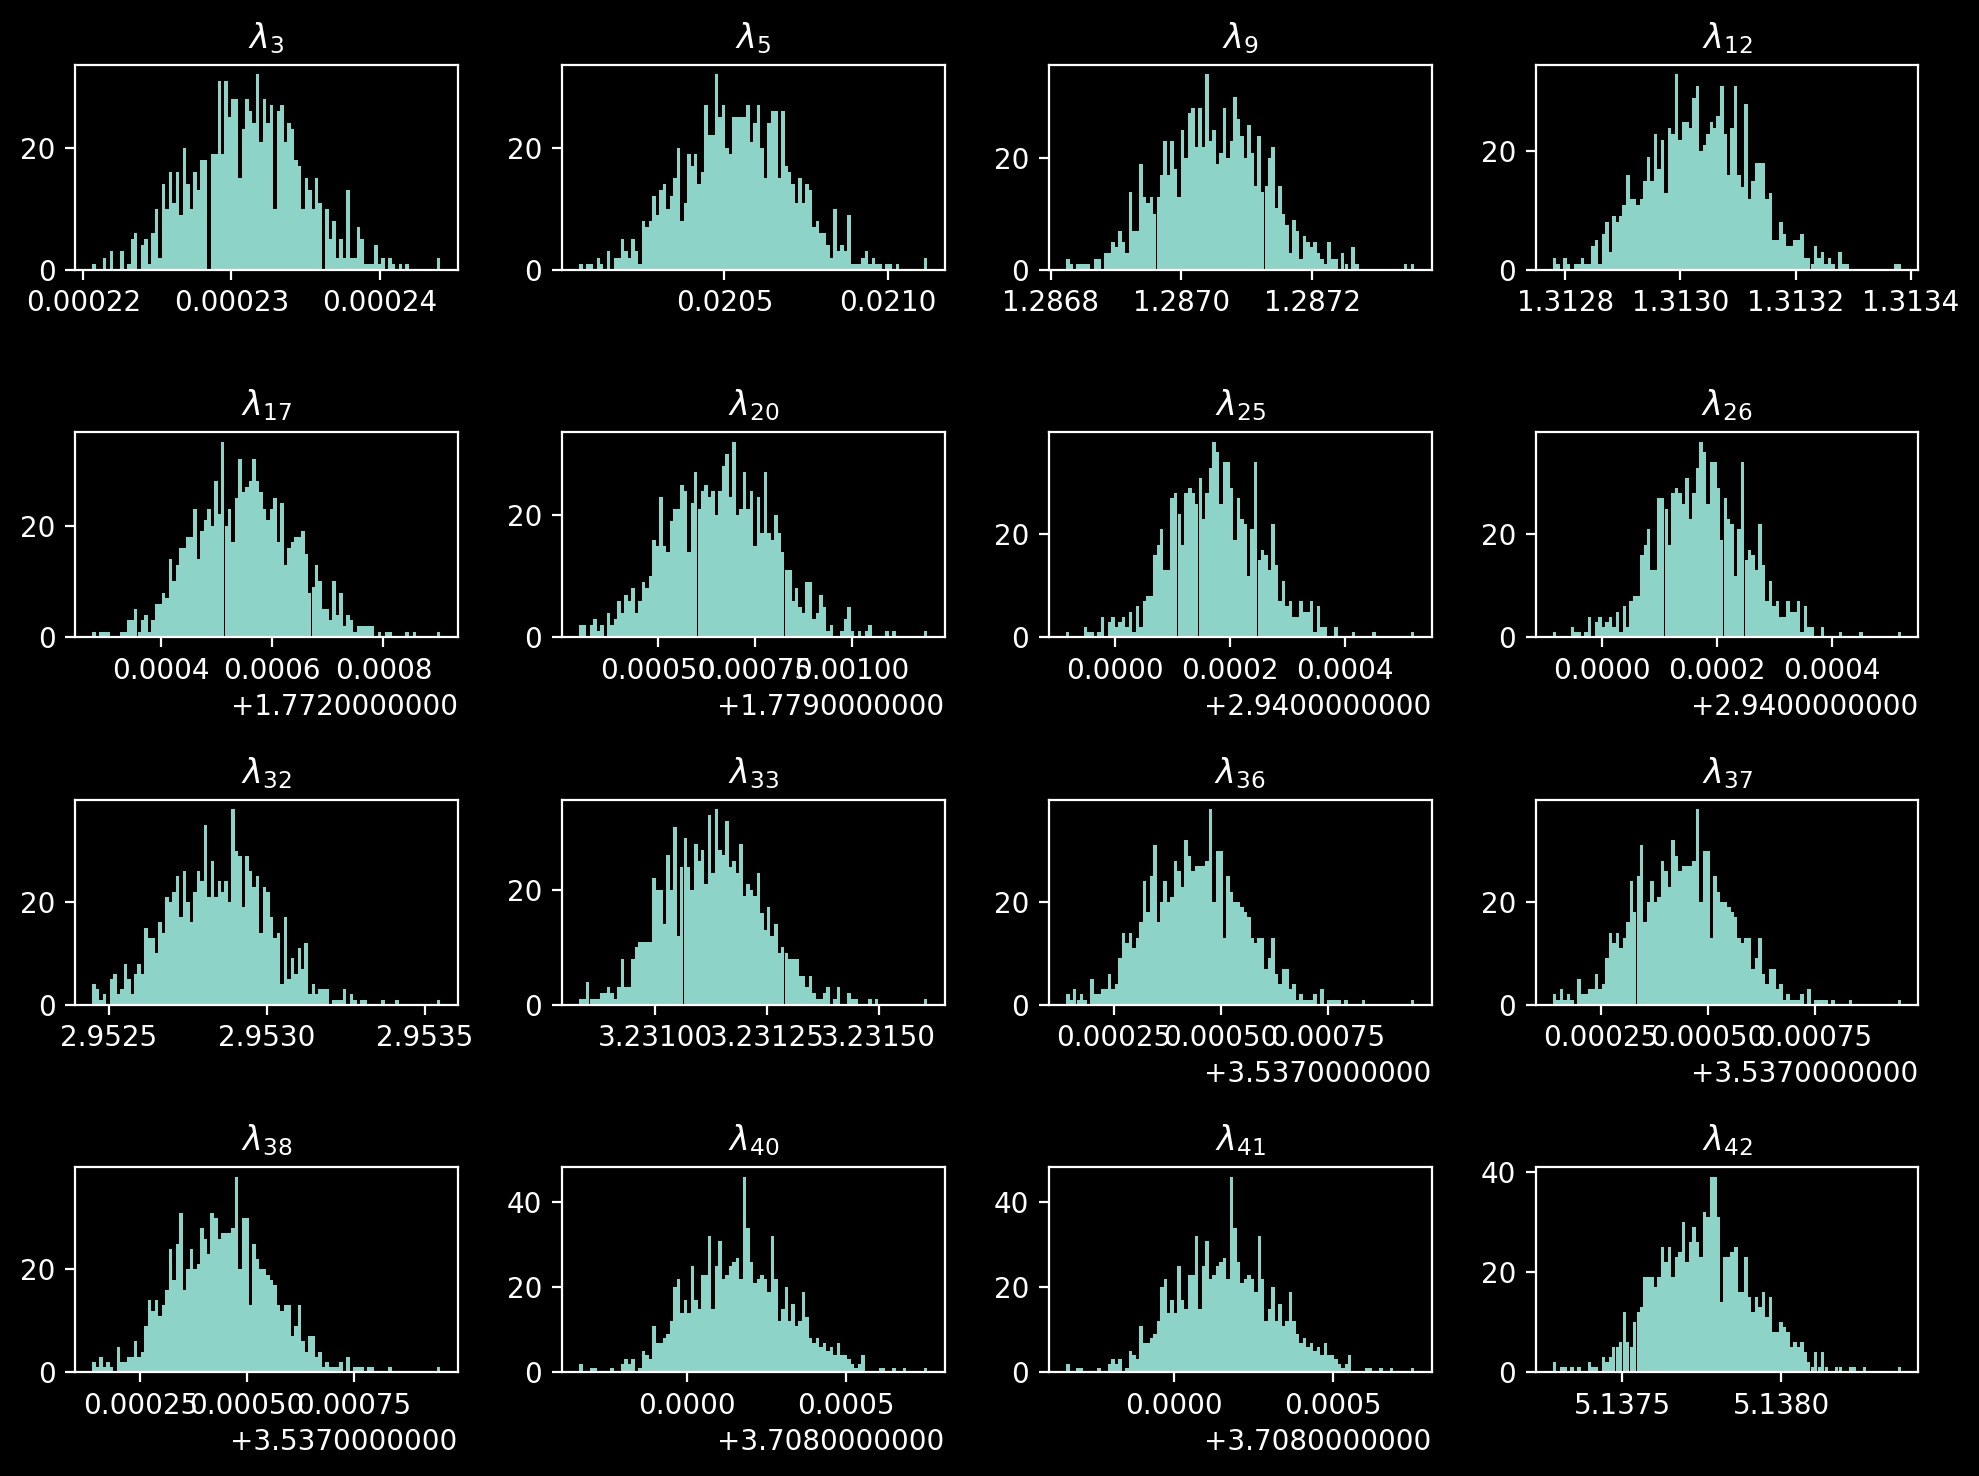

In [263]:
side = 4
num_bins = 100
rand_sample = sorted(sample(range(45), side**2))
fig, axes = plt.subplots(nrows=side, ncols=side, figsize = (10,7.5))
for idx, a_choice in enumerate(rand_sample):
    i, j = idx // side, idx % side 
    axes[i][j].hist(trials[a_choice], num_bins)
    axes[i][j].set_title('$\\lambda_{%d}$' % a_choice)
plt.tight_layout()
plt.show()

# TSK with uncertainty

In [6]:
γexps = {2: 4.42, 3: 4.50, 4: 4.61, 5: 4.48, 6: 4.81, 7: 4.63, 8: 4.71}
Bexps =  {2: 860, 3:918 , 4:965 , 5:860, 6: 1065, 7: 971, 8:1030}
atoms = dict(zip([2,3,4,5,6,7,8], 'V,3 Cr,3 Mn,3 Mn,2 Co,3 Co,2 Ni,2'.split(' ')))
Dqs = np.linspace(0,4,80)
ymax = 75

subs = {sp.Symbol('F_{(4)}') : sp.Symbol('F^{(4)}')/441,
        sp.Symbol('F_{(0)}'): sp.Symbol('F^{(0)}'),
        sp.Symbol('F_{(2)}'): sp.Symbol('F^{(2)}')/49}
A = sp.Symbol('F_{(0)}') - 49 * sp.Symbol('F_{(4)}')
A = A.subs(subs)
B = sp.Symbol('F_{(2)}') - 5 * sp.Symbol('F_{(4)}')
B = B.subs(subs)
C = 35*sp.Symbol('F_{(4)}')
C = C.subs(subs)
slater_to_Racah = sp.solve([sp.Symbol('A') - A, 
                        sp.Symbol('B') - B,
                        sp.Symbol('C') - C],
                        (sp.Symbol('F^{(0)}'), sp.Symbol('F^{(2)}'), sp.Symbol('F^{(4)}')))

N=2


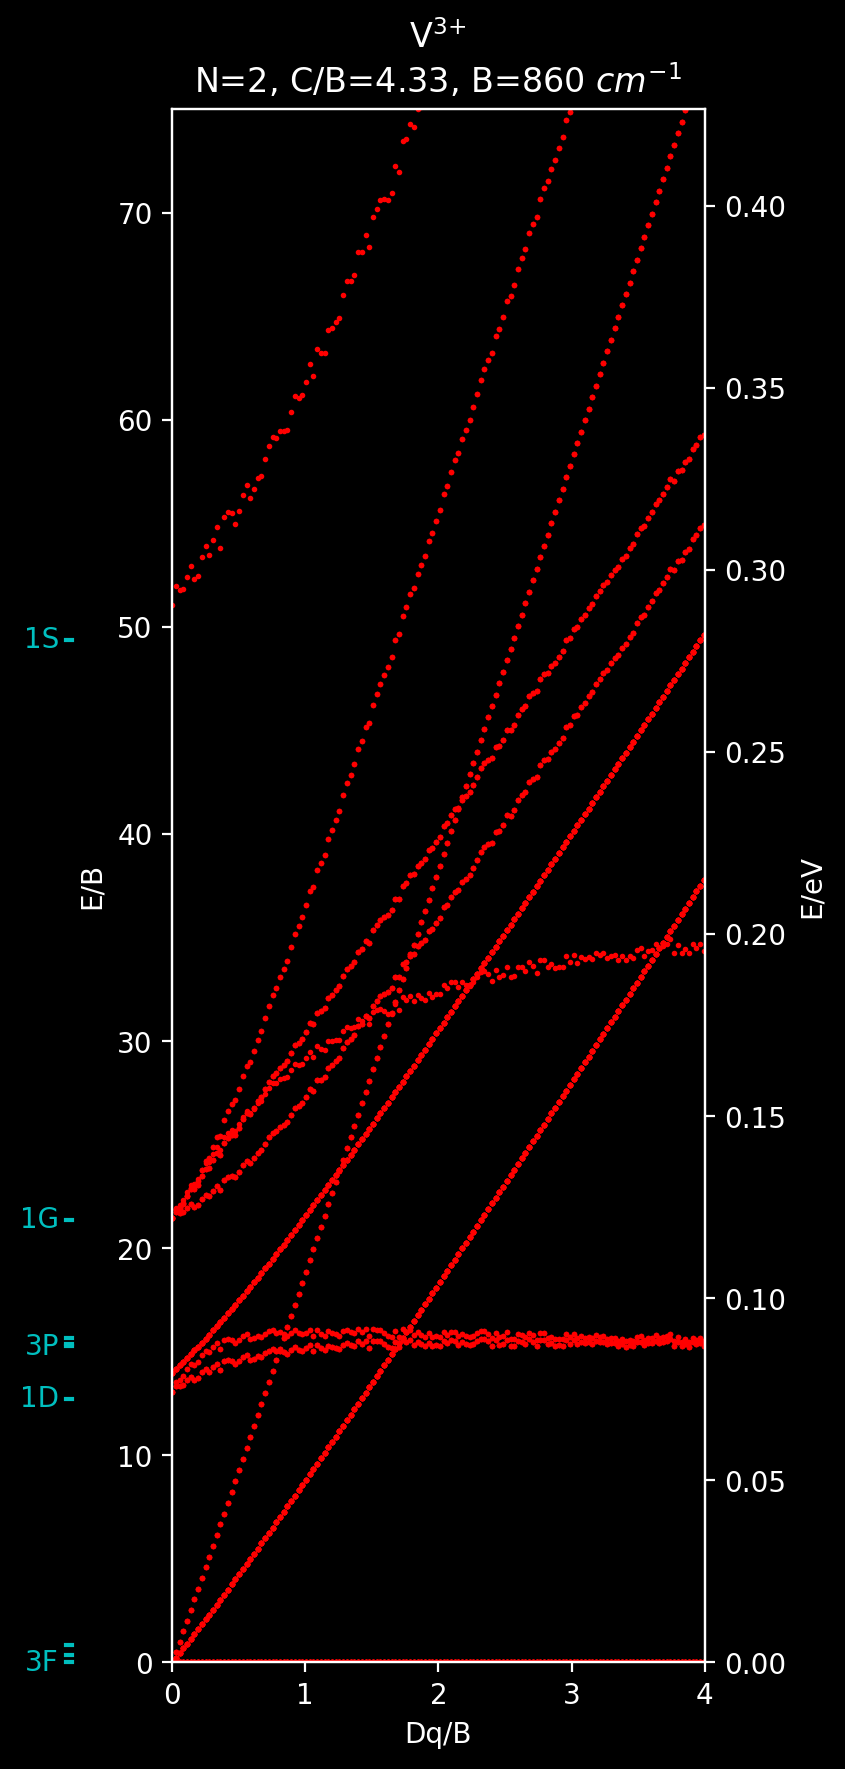

In [63]:
sparse = True
Dqs = np.linspace(5, 0, 180)
ymax = 75
Dqmax = 4.
dγexp = 0.1
αT = 0.1

for num_electrons in [2, 3, 4, 5, 6, 7, 8]:
    print('N=%d' % num_electrons)
    atom = atoms[num_electrons].split(',')[0]
    charge_state =  int(atoms[num_electrons].split(',')[1])
    γexp_0 = γexps[num_electrons]
    ion = Ion(atom, charge_state)
    Bexp = Bexps[num_electrons]

    hamiltonian = hamiltonian_CF_CR_SO_TO(num_electrons, 'O', 2, sparse, False)[0]
    hamiltonian = hamiltonian.subs(slater_to_Racah)
    # A just changes everything by a constant amount
    # B is set to 1 to set it as the unit of energy
    # C is set to gamma, which would be C in units of B
    # B_{4,0} is set to 21*Dq to match standard notation
    hamiltonian = hamiltonian.subs({sp.Symbol('A'): 0, 
                    sp.Symbol('B_{4,0}'): 21*sp.Symbol('Dq'),
                    sp.Symbol('B_{4,0}^r'): 21*sp.Symbol('Dq'),
                    sp.Symbol('B'): 1,
                    sp.Symbol('\\zeta_{SO}'): 0,
                    sp.Symbol('\\alpha_T'): αT,
                    sp.Symbol('C'): sp.Symbol('\\gamma_{CB}')})
    hamlambda = sp.lambdify((sp.Symbol('\\gamma_{CB}'), sp.Symbol('Dq')), hamiltonian)

    all_energies = []
    for Dq in Dqs:
        γexp = γexp_0 + 2*np.random.random()*dγexp - dγexp
        eigensis = np.linalg.eig(hamlambda(γexp, Dq).todense())
        energies = np.real(eigensis[0])
        energies = np.sort(energies)
        all_energies.append(energies)
    all_energies = np.array(all_energies)

    # mbranches = eigenvalue_dismabiguate(all_energies, 2, 10)
    # mbranches = np.array(degen_remove(mbranches))

    exp_levels = ion.nist_data['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}') / Bexp
    term_labels =  ion.nist_data['Term']
    selector = exp_levels < ymax
    exp_levels = exp_levels[selector]
    term_labels = term_labels[selector]

    fig, ax = plt.subplots(figsize=(3*1.5,6*1.5))

    finalbranches = []
    for col in mbranches.T:
        col = col - min(col)
        finalbranches.append(col)

    for row, Dq in zip(all_energies, Dqs):
        plt.plot([Dq]*len(row), row - min(row), 'ro',ms=1)


    y_str = []
    first = True
    for exp_level, term_label in zip(exp_levels, term_labels):
        line = plt.Line2D([-0.8,-0.75], [exp_level]*2, c='c')
        line.set_clip_on(False)
        ax.add_line(line)
        if (len(y_str)>0 and min(([abs(ys - exp_level) for ys in y_str])) > 2) or first:
            plt.text(-.85, exp_level, term_label, ha='right', va='center', c='c')
            first = False
        y_str.append(exp_level)
    plt.xlim(0,Dqmax)
    plt.ylim(0,ymax)
    plt.xlabel('Dq/B')
    plt.ylabel('E/B')
    axright = ax.twinx()  # instantiate a second axes that shares the same x-axis
    axright.set_ylim(0, Dqmax*Bexp*UnitCon.con_factor('cm^{-1}','eV'))
    axright.set_ylabel('E/eV')
    plt.title('%s${}^{%d\!+}$\nN=%d, C/B=%.2f, B=%.0f $cm^{-1}$' % (atom, charge_state, num_electrons, γexp, Bexp))
    plt.tight_layout()
    # plt.savefig('TSK-%d.pdf' % num_electrons)
    plt.show()
    if num_electrons == 2:
        break

In [37]:
sp.S(20000*UnitCon.con_factor('cm^{-1}','J') / (5.3e-11) / 1.602e-19) / 1e9

46.7916300510490

In [41]:
ϵ0 = 8.85e-12
e = 1.602e-19
a0 = 5.3e-11
'{:e}'.format(sp.N(1/4/sp.pi/ϵ0*e/a0**2))

'5.12811360645094e+11'

In [51]:
'{:e}'.format(0.123123)


'1.231230e-01'

In [59]:
'{num0:.3e}, {num1:.2e}'.format(num0=0.123123, num1=112311.1)

'1.231e-01, 1.12e+05'

In [62]:
'{num0:.3e}, {num1:.2e}'.format(**{"num0":0.123123, "num1":112311.1})


'1.231e-01, 1.12e+05'

In [ ]:
''